# Machine Learning Assignment2 - ID3 Decision Tree
By Zihao Cui 13483538

# GitHub Link

In [ ]:
!git clone https://github.com/czh2152215/ID3-decision-tree.git

Cloning into 'ID3-decision-tree'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (9/9), done.


# Read File and Create DataSet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import copy
def createDataSet_tennis():
  dataset = pd.read_csv('./ID3-decision-tree/tennis.csv')
  X = dataset.iloc[:, 1:].values
  values = X.tolist()
  labels = ['outlook', 'temp', 'humidity', 'wind']
  return values, labels


def createDataSet_vote():
  dataset = pd.read_csv('./ID3-decision-tree/Vote.csv')
  X = dataset.drop([1]).values
  values = X.tolist()
  labels = ['handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 
        'physician-fee-freeze','el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban',
        'aid-to-nicaraguan-contras','mx-missile','export-administration-act-south-africa']
  return values, labels

# Calculate Entropy

In [ ]:
#Calculate information Entropy
def calcEnt(dataSet):
    numEntries = len(dataSet)
    #Create dictionaries for categories
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1] #Get the last column of data
        if currentLabel not in labelCounts.keys():
            labelCounts.setdefault(currentLabel, 0)
        labelCounts[currentLabel] += 1

    #Calculate
    inforEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        inforEnt += prob * math.log2(1 / prob) #log base 2
    return inforEnt

# Classification of datasets by information gain

In [ ]:
#Define the function splitDataSet to divide by a feature
#Input three variables (dataset to be split, feature, classification value)
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis] #chop out axis used for splitting
            reduceFeatVec.extend(featVec[axis + 1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet  #returns a subset of features without division

def chooseBestFeatureToSplit(dataSet):
    numFeature = len(dataSet[0]) - 1 #the last column is used for the labels
    # print(numFeature)
    baseEntropy = calcEnt(dataSet)
    bestInforGain = 0
    bestFeature = -1

    for i in range(numFeature):  #iterate over all the features
        featList = [number[i] for number in dataSet] #create a list of all the examples of this feature
        uniqualVals = set(featList) #get a set of unique values
        newEntrogy = 0

        for value in uniqualVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet)) #which is p(xi)
            newEntrogy += prob * calcEnt(subDataSet) #to various subsets seeking Information Entropy

        infoGain = baseEntropy - newEntrogy  #calculate the info gain; ie reduction in entropy

        # Maximum information gain
        if infoGain > bestInforGain: #compare this to the best gain so far
            bestInforGain = infoGain #if better than current best, set to best
            bestFeature = i
    return bestFeature #returns as an integer


# Create Tree

In [ ]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount.setdefault(vote, 0)
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=lambda i:i[1], reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels): #label is the name of features
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0] #stop splitting when all of the classes are equal

    # Determine if all features have been traversed, 
    # and if so, return the category with the highest number of features
    if len(dataSet[0]) == 1:
        return majorityCnt(classList) #stop splitting when there are no more features in dataSet

    #classify features according to highest information gain
    bestFeat = chooseBestFeatureToSplit(dataSet) #Classify the feature
    bestFeatLabel = labels[bestFeat]  #Lable of this feature
    myTree = {bestFeatLabel: {}}
    del (labels[bestFeat]) #remove this label

    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]  #copy all of labels, so trees don't mess up existing labels
        #Constructing subsets of data with recursion
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree


# Predict Data

In [ ]:
def classify(inputTree,featLabels,testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

# Build Plot Tree Diagram

In [ ]:
import matplotlib.pyplot as plt

from pylab import *  
decisionNode=dict(boxstyle='sawtooth',fc='0.8') #decision node
leafNode=dict(boxstyle='round4',fc='0.8')#leaf node
arrow_args=dict(arrowstyle='<-') #Arrow

def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,xycoords='axes fraction',
                xytext=centerPt,textcoords='axes fraction',
                va='center',ha='center',bbox=nodeType,arrowprops=arrow_args)

def createPlot():
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    createPlot.ax1=plt.subplot(111,frameon=False)
    plotNode('Decision nodes',(0.5,0.1),(0.1,0.5),decisionNode)
    plotNode('leaf nodes',(0.8,0.1),(0.3,0.8),leafNode)
    plt.show()

#Get the number of leaf nodes (breadth)
def getNumLeafs(myTree):
    numLeafs=0
    firstStr=list(myTree.keys())[0]#'dict_keys' object does not support indexing
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs+=getNumLeafs(secondDict[key])
        else:numLeafs+=1
    return numLeafs

#Functions to get the depth of a tree (depth)
def getTreeDepth(myTree):
    maxDepth=0
    firstStr=list(myTree.keys())[0]
    secondDict=myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            thisDepth=1+getTreeDepth(secondDict[key])
        else: thisDepth=1
        if thisDepth > maxDepth:
            maxDepth=thisDepth
    return maxDepth

#fills in text information between parent and child nodes
def plotMidText(cntrPt,parentPt,txtString):
    xMid=(parentPt[0]-cntrPt[0])/2+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2+cntrPt[1]
    createPlot.ax1.text(xMid,yMid,txtString)

#tree drawing    
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs=getNumLeafs(myTree)
    depth=getTreeDepth(myTree)
    firstStr=list(myTree.keys())[0]
    cntrPt=(plotTree.xOff+(1.0+float(numLeafs))/2/plotTree.totalW,plotTree.yOff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict=myTree[firstStr]
    plotTree.yOff=plotTree.yOff -1/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plotNode(secondDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    plotTree.yOff=plotTree.yOff+1/plotTree.totalD

#main function to call other functions   
def createPlot(inTree):
    fig=plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW=float(getNumLeafs(inTree))
    plotTree.totalD=float(getTreeDepth(inTree))
    plotTree.xOff=-0.5/plotTree.totalW;plotTree.yOff=1.0;
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

# Vote DataSet 

In [ ]:
myDat,labels = createDataSet_vote()
myDat

[['y', 'y', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'y', 'y', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'democrat'],
 ['n', 'n', 'n', 'y', 'y', 'n', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'y', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'democrat'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'n', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'y', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'y', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],
 ['n', 'y', 'n', 'y', 'y', 'y', 'n', 'n', 'n', 'n', 'republican'],

In [ ]:
calcEnt(myDat)

0.999926399368686

In [ ]:
voteTree=createTree(myDat,labels)
voteTree

{'physician-fee-freeze': {'n': {'adoption-of-the-budget-resolution': {'n': {'religious-groups-in-schools': {'n': {'water-project-cost-sharing': {'n': {'export-administration-act-south-africa': {'democrat': 'democrat',
          'republican': 'republican'}},
        'y': 'democrat'}},
      'y': 'democrat'}},
    'y': 'democrat'}},
  'y': {'adoption-of-the-budget-resolution': {'n': {'el-salvador-aid': {'n': {'handicapped-infants': {'n': 'republican',
        'y': 'democrat'}},
      'y': {'export-administration-act-south-africa': {'n': {'handicapped-infants': {'n': {'religious-groups-in-schools': {'n': 'republican',
            'y': {'water-project-cost-sharing': {'n': {'mx-missile': {'democrat': 'democrat',
                'republican': 'republican'}},
              'y': {'mx-missile': {'democrat': 'democrat',
                'republican': 'republican'}}}}}},
          'y': 'republican'}},
        'y': 'republican'}}}},
    'y': {'anti-satellite-test-ban': {'n': {'water-project-cost-sh

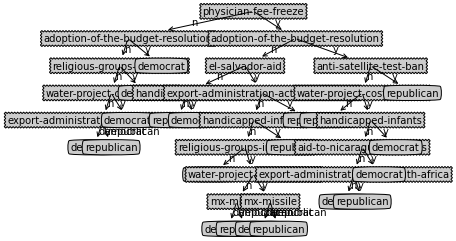

In [ ]:
createPlot(voteTree)

In [ ]:
dataset = pd.read_csv('./ID3-decision-tree/Vote_pre.csv',header=None)
Y = dataset.drop([10],axis=1)
X = Y.values
tests = X.tolist()
labels = ['handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 
      'physician-fee-freeze','el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban',
      'aid-to-nicaraguan-contras','mx-missile','export-administration-act-south-africa']
for test in tests:
  print(classify(voteTree,labels,test))

democrat
democrat
democrat
democrat
democrat
democrat
democrat
democrat
democrat
democrat
democrat
republican
republican
republican
democrat
democrat
republican
democrat
democrat
democrat
democrat
democrat
democrat
democrat
democrat
republican
republican
republican
democrat
republican
republican


# Tennis DataSet

In [ ]:
myDat,labels = createDataSet_tennis()
calcEnt(myDat)

0.9402859586706309

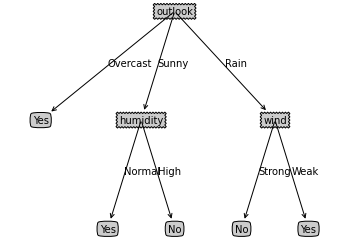

In [ ]:
tennisTree=createTree(myDat,labels)
createPlot(tennisTree)

In [ ]:
tennisTree

{'outlook': {'Overcast': 'Yes',
  'Rain': {'wind': {'Strong': 'No', 'Weak': 'Yes'}},
  'Sunny': {'humidity': {'High': 'No', 'Normal': 'Yes'}}}}

In [ ]:
labels = ['outlook', 'temp', 'humidity', 'wind']
dataset = pd.read_csv('./ID3-decision-tree/tennis_pre.csv',header=None)
Y = dataset.drop([4],axis=1)
X = Y.values
tests = X.tolist()

for test in tests:
  print(classify(tennisTree,labels,test))

Yes
Yes
Yes
No
Yes
